## Tests of the pre-DR7 code base

The purpose of this notebook is to compare a small number of Tractor catalogs from DR5 against the version of the pipeline we hope to use for DR7.  Some of the major changes include:
* More careful treatment of sources in and around bright stars.
* A source-detection step which uses the coadds to find faint sources.
* Use of Gaia and Tycho2 as (prior) input catalogs.

In [1]:
import os
from glob import glob
import numpy as np
import fitsio
import matplotlib.pyplot as plt

In [2]:
from astrometry.libkd.spherematch import match_radec
from astropy.table import Table, vstack

In [3]:
%matplotlib inline

In [4]:
def read_tractor():
    """Read the old and new Tractor catalogs."""
    
    # First read the pre-DR7 catalogs.
    dr7dir = '/global/cscratch1/sd/dstn/dr7-lg'
    dr7files = glob('{}/tractor/???/tractor-*.fits'.format(dr7dir))
    cat = []
    for ii, dr7file in enumerate(dr7files):
        if (ii % 100) == 0:
            print('Read {:03d} / {:03d} pre-DR7 Tractor catalogs.'.format(ii, len(dr7files)))
        cat.append(Table(fitsio.read(dr7file, ext=1, lower=True)))
    dr7 = vstack(cat)
    
    # Now read the corresponding DR5 catalogs.
    dr5dir = '/global/project/projectdirs/cosmo/data/legacysurvey/dr5'
    dr5files = [ff.replace(dr7dir, dr5dir) for ff in dr7files]
    cat = []
    for ii, dr5file in enumerate(dr5files):
        if (ii % 100) == 0:
            print('Read {:03d} / {:03d} DR5 Tractor catalogs.'.format(ii, len(dr5files)))
        cat.append(Table(fitsio.read(dr5file, ext=1, lower=True)))
    dr5 = vstack(cat)
    
    dr5 = dr5[dr5['brick_primary']]
    dr7 = dr7[dr7['brick_primary']]
    
    return dr5, dr7

In [5]:
%time dr5, dr7 = read_tractor()
print('Read {} DR5 and {} pre-DR7 sources.'.format(len(dr5), len(dr7)))

Read 000 / 241 pre-DR7 Tractor catalogs.
Read 100 / 241 pre-DR7 Tractor catalogs.
Read 200 / 241 pre-DR7 Tractor catalogs.
Read 000 / 241 DR5 Tractor catalogs.
Read 100 / 241 DR5 Tractor catalogs.
Read 200 / 241 DR5 Tractor catalogs.
CPU times: user 34.9 s, sys: 7.48 s, total: 42.4 s
Wall time: 48.5 s
Read 1190812 DR5 and 1333040 pre-DR7 sources.


### What sources are in DR7 but not DR5, and in DR5 but not DR7?
Use a 1 arcsec search radius.

In [6]:
m1, m2, d12 = match_radec(dr7['ra'], dr7['dec'], dr5['ra'], dr5['dec'], 1./3600.0, nearest=True)
in_dr7_not_dr5 = np.delete(np.arange(len(dr7)), m1)
in_dr5_not_dr7 = np.delete(np.arange(len(dr5)), m2)

In [7]:
def qa_radec():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    ax1.hexbin(dr5['ra'], dr5['dec'], mincnt=1)
    ax1.set_title('All DR5 Sources (N={})'.format(len(dr5)))
                  
    ax3.hexbin(dr5['ra'][in_dr5_not_dr7], dr5['dec'][in_dr5_not_dr7], mincnt=1)
    ax3.set_title('In DR5, not DR7 (N={})'.format(len(in_dr5_not_dr7)))
    
    ax2.hexbin(dr7['ra'], dr7['dec'], mincnt=1)
    ax2.set_title('All DR7 Sources (N={})'.format(len(dr7)))
    
    ax4.hexbin(dr7['ra'][in_dr7_not_dr5], dr7['dec'][in_dr7_not_dr5], mincnt=1)
    ax4.set_title('In DR7, not DR5 (N={})'.format(len(in_dr7_not_dr5)))
    
    fig.subplots_adjust(wspace=0.02, hspace=0.2)

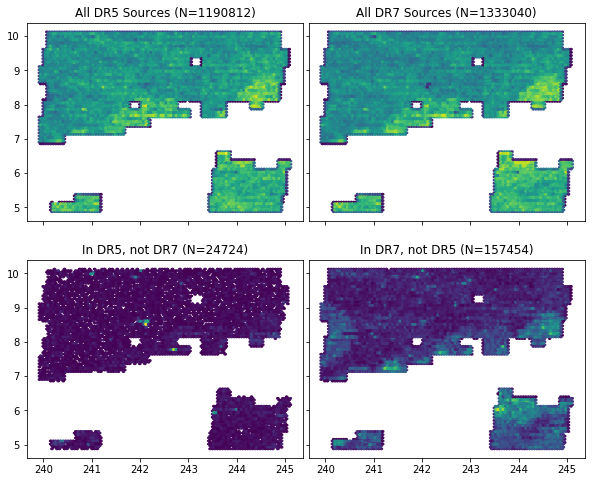

In [8]:
qa_radec()

### Study sources in and around bright stars.

In [9]:
def qa_brightstars(magcut=10):
    istar = np.logical_or(dr7['ref_cat'] == 'T2', dr7['ref_cat'] == 'G2')
    ibright = np.logical_and(istar, dr7['gaia_phot_g_mean_mag'] < magcut)
    instar = dr7['brightstarinblob']
    print('Found {} m<{:.1f} (bright) stars.'.format(np.sum(ibright), magcut))
    print('Found {} sources around all {} Gaia/Tycho-2 stars.'.format(np.sum(instar), np.sum(istar)))

    fig, ax = plt.subplots()
    ax.scatter(dr7['ra'][ibright], dr7['dec'][ibright], s=30, 
               label='Bright Stars (m<{:.1f})'.format(magcut))
    ax.scatter(dr7['ra'][instar], dr7['dec'][instar], s=2, alpha=0.6, 
               label='Sources around All Stars')
    ax.legend(loc='lower left')
    
    print('Sources in and around bright stars have type(s) = {}'.format(', '.join(np.unique(dr7['type'][instar]))))

Found 122 m<10.0 (bright) stars.
Found 15517 sources around all 140220 Gaia/Tycho-2 stars.
Sources in and around bright stars have type(s) = PSF 


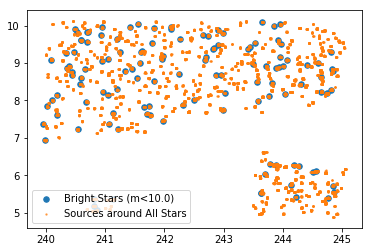

In [10]:
qa_brightstars()